# Step 1: Business understanding
Hiện tại: Công ty kinh doanh quả bơ ở rất nhiều vùng của
nước Mỹ với 2 loại bơ là bơ thường và bơ hữu cơ. Hai loại bơ này được
đóng gói theo nhiều quy chuẩn (Small/Large/XLarge Bags),
và có 3 PLU (Product Look Up) khác nhau (4046, 4225,
4770). Hiện tại, công ty đang có nhu cầu mở rộng vậy nên họ cần một mô hình dự đoán giá bơ
để xem xét những yếu tố tiềm ẩn và tiềm năng cho việc mở rộng sản xuất.

=> Mục tiêu/ Vấn đề: Xây dựng mô hình dự đoán giá trung
bình của bơ “Hass” ở Mỹ => xem xét việc mở rộng sản xuất,
kinh doanh.

## Preparing toolkit (import libraries)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling as pp
from scipy.stats import chi2_contingency, f_oneway, chisquare
import time
import phik

#For feature engineering
from sklearn.base import TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

#Model
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

#Evalution Model
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error


def line(sep = '*'):
    print('\n'+sep*20)

In [2]:
# Custom css for data visualization
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.titlesize': 'x-large',
          'figure.figsize': (13, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

# Step 2: Data understanding

## Data context
Dữ liệu được lấy trực tiếp từ máy tính tiền của các nhà bán
lẻ dựa trên doanh số bán lẻ thực tế của bơ Hass.

Dữ liệu đại diện cho dữ liệu lấy từ máy quét bán lẻ hàng
tuần cho lượng bán lẻ (National retail volume- units) và giá
bơ từ tháng 4/2015 đến tháng 3/2018.

Giá Trung bình (Average Price) trong bảng phản ánh giá
trên một đơn vị (mỗi quả bơ), ngay cả khi nhiều đơn vị (bơ)
được bán trong bao.

Mã tra cứu sản phẩm - Product Lookup codes (PLU’s) trong
bảng chỉ dành cho bơ Hass, không dành cho các sản phẩm
khác.

## Data content
Toàn bộ dữ liệu được đổ ra và lưu trữ trong tập tin avocado.csv
với 18249 record. Với các cột:
 Date - ngày ghi nhận
 AveragePrice – giá trung bình của một quả bơ
 Type - conventional / organic – loại: thông thường/ hữu cơ
 Region – vùng được bán
 Total Volume – tổng số bơ đã bán
 4046 – tổng số bơ có mã PLU 4046 đã bán
 4225 - tổng số bơ có mã PLU 4225 đã bán
 4770 - tổng số bơ có mã PLU 4770 đã bán
 Total Bags – tổng số túi đã bán
 Small/Large/XLarge Bags – tổng số túi đã bán theo size

Có hai loại bơ trong tập dữ liệu và một số vùng khác nhau. Điều
này cho phép chúng ta thực hiện tất cả các loại phân tích cho
các vùng khác nhau, hoặc phân tích toàn bộ nước Mỹ theo một
trong hai loại bơ.

In [3]:
#Load data
df = pd.read_csv('avocado.csv', index_col=0)
df

Date  AveragePrice  Total Volume     4046       4225    4770  \
0   2015-12-27          1.33      64236.62  1036.74   54454.85   48.16   
1   2015-12-20          1.35      54876.98   674.28   44638.81   58.33   
2   2015-12-13          0.93     118220.22   794.70  109149.67  130.50   
3   2015-12-06          1.08      78992.15  1132.00   71976.41   72.58   
4   2015-11-29          1.28      51039.60   941.48   43838.39   75.78   
..         ...           ...           ...      ...        ...     ...   
7   2018-02-04          1.63      17074.83  2046.96    1529.20    0.00   
8   2018-01-28          1.71      13888.04  1191.70    3431.50    0.00   
9   2018-01-21          1.87      13766.76  1191.92    2452.79  727.94   
10  2018-01-14          1.93      16205.22  1527.63    2981.04  727.01   
11  2018-01-07          1.62      17489.58  2894.77    2356.13  224.53   

    Total Bags  Small Bags  Large Bags  XLarge Bags          type  year  \
0      8696.87     8603.62       93.25          0.0  conventional  2015   
1      9505.56     9408.07       97.49          0.0  conventional  2015   
2      8145.35     8042.21      103.14          0.0  conventional  2015   
3      5811.16     5677.40      133.76          0.0  conventional  2015   
4      6183.95     5986.26      197.69          0.0  conventional  2015   
..         ...         ...         ...          ...           ...   ...   
7     13498.67    13066.82      431.85          0.0       organic  2018   
8      9264.84     8940.04      324.80          0.0       organic  2018   
9      9394.11     9351.80       42.31          0.0       organic  2018   
10    10969.54    10919.54       50.00          0.0       organic  2018   
11    12014.15    11988.14       26.01          0.0       organic  2018   

              region  
0             Albany  
1             Albany  
2             Albany  
3             Albany  
4             Albany  
..               ...  
7   WestTexNewMexico  
8   WestTexNewMexico  
9   WestTexNewMexico  
10  WestTexNewMexico  
11  WestTexNewMexico  

[18249 rows x 13 columns]

In [4]:
#Take an overall look at df
profile = pp.ProfileReport(df)
profile

Summarize dataset:   0%|          | 0/26 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Data diagnose
Nhìn chung chúng ta thấy, dữ liệu khá sạch và được thu thập một cách kĩ càng và có cân nhắc. Các record ở mỗi region đều như nhau, không có chênh lệch giữa các categorical features. Không có dữ liệu thiếu và trùng lắp. Ngoài ra, dữ liệu chỉ tập trung vào các cột có kiểu theo thời gian, không gian, loại bơ, giá bán và tổng số sản phẩm đã bán.

Tuy nhiên vẫn còn một số lỗi nhỏ có bên trong dữ liệu như sau:
1. Có các cột có tương quan cao với nhau: Total Volume - 4046,4225,Total Bags, Small Bags, Large Bags (Nhưng cột này đều thể hiện số lượng bơ đã bán trong một tháng). Vì thế ta chỉ cần giữ lại Total Volume để train model, các thuộc tính còn lại chúng ta sẽ dùng cho các việc phân tích.
2. Vì đây là bài toán regression, nên chúng ta phải giải quyết được cột time seriese trước khi áp dụng vào model. Phương pháp thì chúng ta có thể group thời gian theo mùa.

# Step 3: Data cleaning, creating, correcting


In [5]:
# Remove high correlation features
data = df[['Date', 'Total Volume', 'region', 'type', 'year', 'AveragePrice']]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18249 entries, 0 to 11
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          18249 non-null  object 
 1   Total Volume  18249 non-null  float64
 2   region        18249 non-null  object 
 3   type          18249 non-null  object 
 4   year          18249 non-null  int64  
 5   AveragePrice  18249 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 998.0+ KB


In [6]:
# Cast data object to datetime data type
df['Date'] = pd.to_datetime(df['Date'])
data['Date'] = pd.to_datetime(data['Date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18249 entries, 0 to 11
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          18249 non-null  datetime64[ns]
 1   Total Volume  18249 non-null  float64       
 2   region        18249 non-null  object        
 3   type          18249 non-null  object        
 4   year          18249 non-null  int64         
 5   AveragePrice  18249 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 998.0+ KB


C:\Users\PC\anaconda3\envs\dstn\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
# Creating season features
def to_season(date):
    month = date.month
    if month <= 3:
        return 'Spring'
    elif month <= 6:
        return 'Summer'
    elif month <= 9:
        return 'Fall'
    else:
        return 'Winter'


data['season'] = data['Date'].apply(lambda x: to_season(x))
data['season'].value_counts()

C:\Users\PC\anaconda3\envs\dstn\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Spring    5508
Winter    4319
Fall      4212
Summer    4210
Name: season, dtype: int64

In [8]:
# Same as df
df.loc[:, 'season'] = df['Date'].apply(lambda x: to_season(x))
df['season'].value_counts()

Spring    5508
Winter    4319
Fall      4212
Summer    4210
Name: season, dtype: int64

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18249 entries, 0 to 11
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          18249 non-null  datetime64[ns]
 1   Total Volume  18249 non-null  float64       
 2   region        18249 non-null  object        
 3   type          18249 non-null  object        
 4   year          18249 non-null  int64         
 5   AveragePrice  18249 non-null  float64       
 6   season        18249 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 1.1+ MB


In [10]:
# Drop datetime columns
data.drop(columns = 'Date', inplace=True)

C:\Users\PC\anaconda3\envs\dstn\lib\site-packages\pandas\core\frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [11]:
data[['AveragePrice', 'Total Volume']].describe()

AveragePrice  Total Volume
count  18249.000000  1.824900e+04
mean       1.405978  8.506440e+05
std        0.402677  3.453545e+06
min        0.440000  8.456000e+01
25%        1.100000  1.083858e+04
50%        1.370000  1.073768e+05
75%        1.660000  4.329623e+05
max        3.250000  6.250565e+07

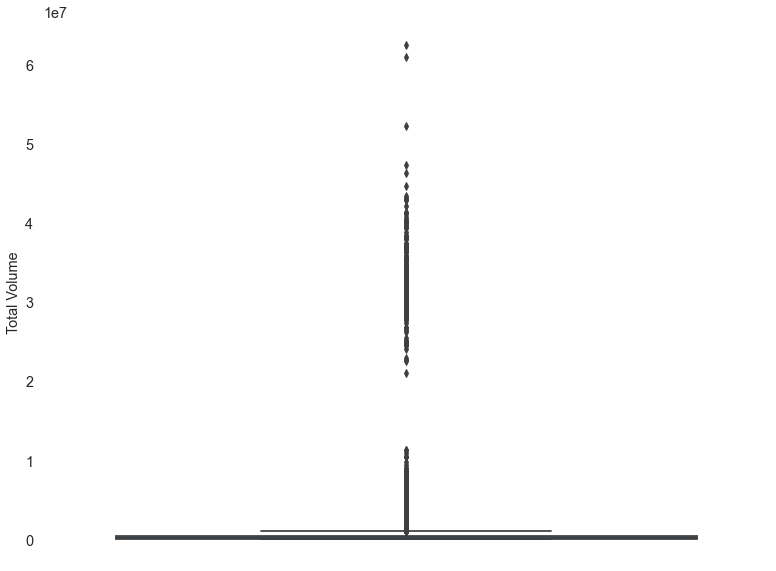

In [12]:
sns.boxplot(y = df['Total Volume']);

Nhiều outliers quá nhỉ :)). Ừm với trường hợp này thì chúng ta có thể nghĩ ngay đến log transformation, để chuẩn hóa dữ liệu.

C:\Users\PC\anaconda3\envs\dstn\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


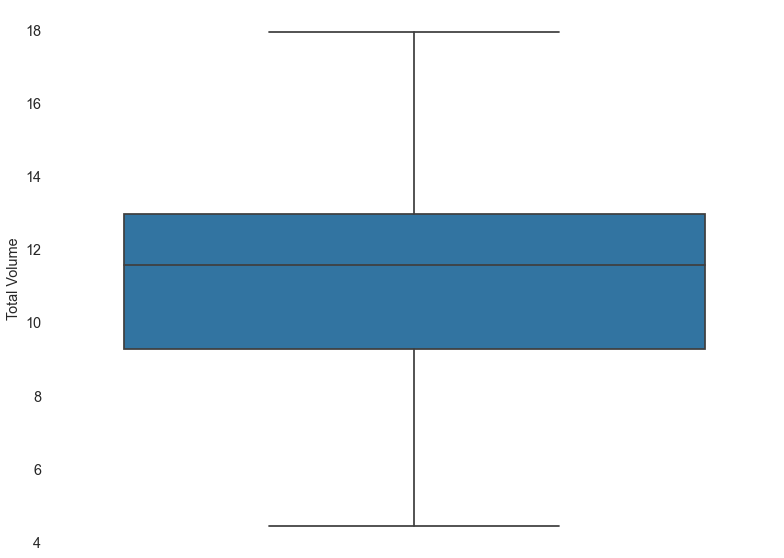

In [13]:
data.loc[:,'Total Volume'] = np.log1p(data['Total Volume'])
sns.boxplot(y = data['Total Volume']);

OK nhìn đẹp hơn rồi đấy, có phân phối chuẩn luôn này, ngon.

In [14]:
#Scaling numerical feature
scaler = StandardScaler()
data[ 'Total Volume'] = scaler.fit_transform(data[['Total Volume']])
data[['AveragePrice', 'Total Volume']].describe()

C:\Users\PC\anaconda3\envs\dstn\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


AveragePrice  Total Volume
count  18249.000000  1.824900e+04
mean       1.405978  4.983806e-17
std        0.402677  1.000027e+00
min        0.440000 -2.994377e+00
25%        1.100000 -8.831700e-01
50%        1.370000  1.167411e-01
75%        1.660000  7.247156e-01
max        3.250000  2.892877e+00

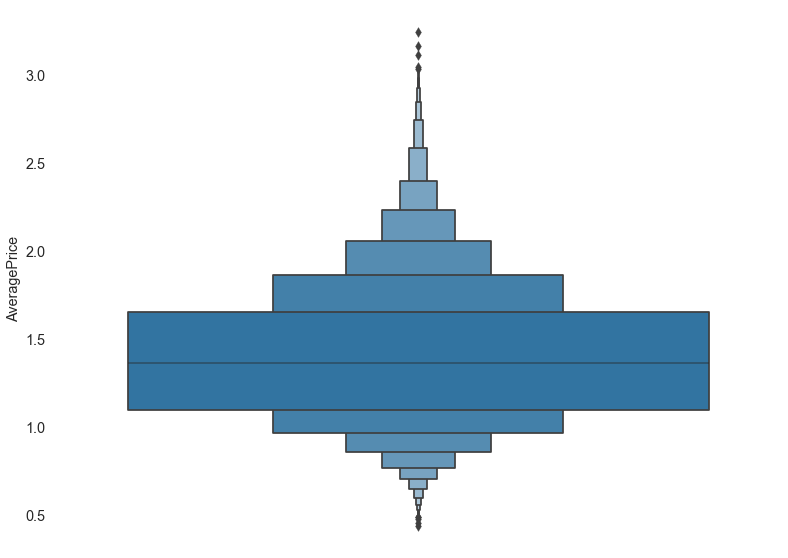

In [15]:
sns.boxenplot(y = data['AveragePrice']);

Chúng ta có một số outlier nhỏ, có một vài tháng trung bình giá bơ tăng hơn 3.0$. Nên cân nhắc drop những record này vì chúng gay nhiễu đáng kể đến model sau này.

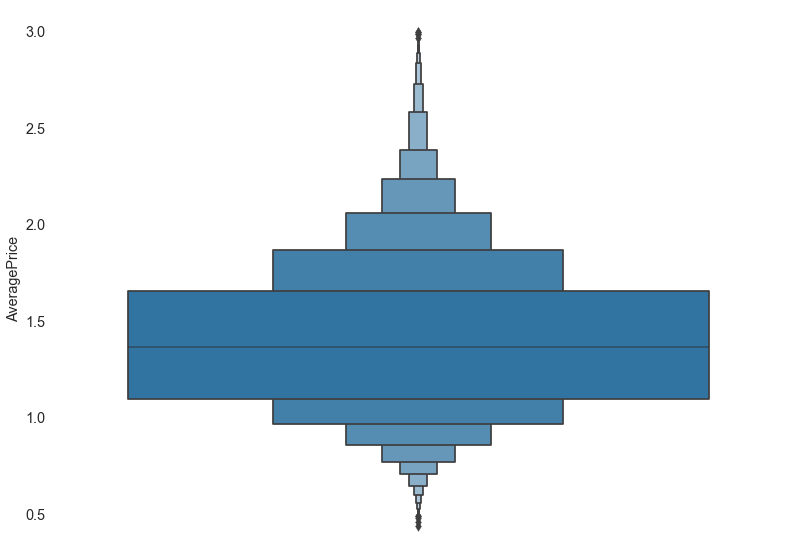

In [16]:
data = data[~(data['AveragePrice'] > 3.0)]
df = df[~(df['AveragePrice'] > 3.0)]
sns.boxenplot(y = data['AveragePrice']);

In [17]:
data.columns

Index(['Total Volume', 'region', 'type', 'year', 'AveragePrice', 'season'], dtype='object')

In [18]:
# See correlation between categorical and target
def get_p_oneway(data, column):
    arr = []
    for unique in data[column].unique():
        arr.append(data.loc[data[column] == unique, 'AveragePrice'])
    stat, p = f_oneway(*arr)
    return p

one_ways = pd.DataFrame(columns=['feature', 'p-value', 'relation_with_target'])
row = 0
for c in ['region', 'type', 'season']:
    one_ways.loc[row, 'feature'] = c
    p = get_p_oneway(data, c)
    one_ways.loc[row, 'p-value'] = p
    one_ways.loc[row, 'relation_with_target'] = p <= 0.05
    row+=1


one_ways.sort_values(by='p-value')

feature p-value relation_with_target
0  region     0.0                 True
1    type     0.0                 True
2  season     0.0                 True

In [19]:
# Encoding categorical features
# Drop year feature, because it is also a time series, we should prevent any time factor to our model. Because we want to focus on region, type, and season.
data.drop(columns='year', inplace=True)
data = pd.get_dummies(data, drop_first=True)
data.head()

Total Volume  AveragePrice  region_Atlanta  region_BaltimoreWashington  \
0     -0.107282          1.33               0                           0   
1     -0.175949          1.35               0                           0   
2      0.158690          0.93               0                           0   
3     -0.017121          1.08               0                           0   
4     -0.207558          1.28               0                           0   

   region_Boise  region_Boston  region_BuffaloRochester  region_California  \
0             0              0                        0                  0   
1             0              0                        0                  0   
2             0              0                        0                  0   
3             0              0                        0                  0   
4             0              0                        0                  0   

   region_Charlotte  region_Chicago  ...  region_StLouis  region_Syracuse  \
0                 0               0  ...               0                0   
1                 0               0  ...               0                0   
2                 0               0  ...               0                0   
3                 0               0  ...               0                0   
4                 0               0  ...               0                0   

   region_Tampa  region_TotalUS  region_West  region_WestTexNewMexico  \
0             0               0            0                        0   
1             0               0            0                        0   
2             0               0            0                        0   
3             0               0            0                        0   
4             0               0            0                        0   

   type_organic  season_Spring  season_Summer  season_Winter  
0             0              0              0              1  
1             0              0              0              1  
2             0              0              0              1  
3             0              0              0              1  
4             0              0              0              1  

[5 rows x 59 columns]

# Step 4: EDA

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18243 entries, 0 to 11
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          18243 non-null  datetime64[ns]
 1   AveragePrice  18243 non-null  float64       
 2   Total Volume  18243 non-null  float64       
 3   4046          18243 non-null  float64       
 4   4225          18243 non-null  float64       
 5   4770          18243 non-null  float64       
 6   Total Bags    18243 non-null  float64       
 7   Small Bags    18243 non-null  float64       
 8   Large Bags    18243 non-null  float64       
 9   XLarge Bags   18243 non-null  float64       
 10  type          18243 non-null  object        
 11  year          18243 non-null  int64         
 12  region        18243 non-null  object        
 13  season        18243 non-null  object        
dtypes: datetime64[ns](1), float64(9), int64(1), object(3)
memory usage: 2.1+ MB


In [21]:
df.head()

Date  AveragePrice  Total Volume     4046       4225    4770  \
0 2015-12-27          1.33      64236.62  1036.74   54454.85   48.16   
1 2015-12-20          1.35      54876.98   674.28   44638.81   58.33   
2 2015-12-13          0.93     118220.22   794.70  109149.67  130.50   
3 2015-12-06          1.08      78992.15  1132.00   71976.41   72.58   
4 2015-11-29          1.28      51039.60   941.48   43838.39   75.78   

   Total Bags  Small Bags  Large Bags  XLarge Bags          type  year  \
0     8696.87     8603.62       93.25          0.0  conventional  2015   
1     9505.56     9408.07       97.49          0.0  conventional  2015   
2     8145.35     8042.21      103.14          0.0  conventional  2015   
3     5811.16     5677.40      133.76          0.0  conventional  2015   
4     6183.95     5986.26      197.69          0.0  conventional  2015   

   region  season  
0  Albany  Winter  
1  Albany  Winter  
2  Albany  Winter  
3  Albany  Winter  
4  Albany  Winter

In [22]:
df.tail()

Date  AveragePrice  Total Volume     4046     4225    4770  \
7  2018-02-04          1.63      17074.83  2046.96  1529.20    0.00   
8  2018-01-28          1.71      13888.04  1191.70  3431.50    0.00   
9  2018-01-21          1.87      13766.76  1191.92  2452.79  727.94   
10 2018-01-14          1.93      16205.22  1527.63  2981.04  727.01   
11 2018-01-07          1.62      17489.58  2894.77  2356.13  224.53   

    Total Bags  Small Bags  Large Bags  XLarge Bags     type  year  \
7     13498.67    13066.82      431.85          0.0  organic  2018   
8      9264.84     8940.04      324.80          0.0  organic  2018   
9      9394.11     9351.80       42.31          0.0  organic  2018   
10    10969.54    10919.54       50.00          0.0  organic  2018   
11    12014.15    11988.14       26.01          0.0  organic  2018   

              region  season  
7   WestTexNewMexico  Spring  
8   WestTexNewMexico  Spring  
9   WestTexNewMexico  Spring  
10  WestTexNewMexico  Spring  
11  WestTexNewMexico  Spring

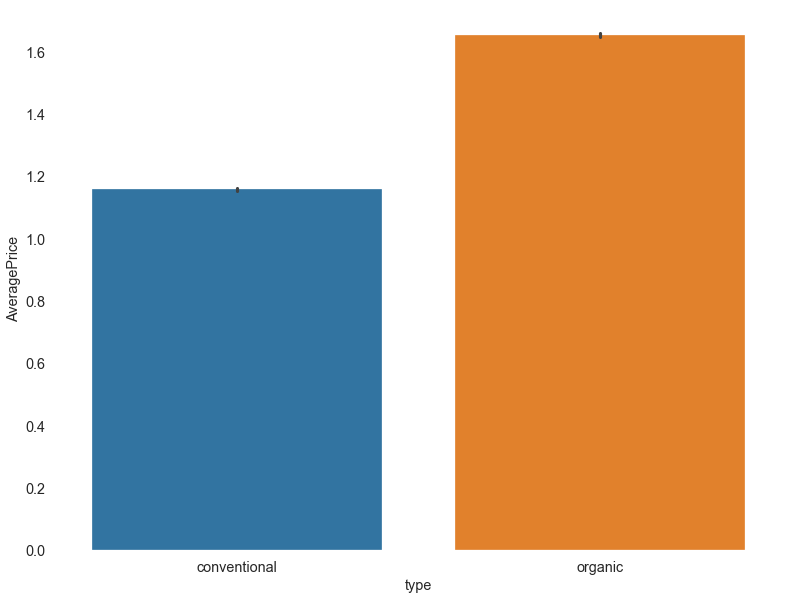

In [23]:
# Does type of avocado affect its price?
sns.barplot(data=df, x='type', y="AveragePrice");

Có lẽ như bơ hữa cơ mắc hơn bơ thông thường.

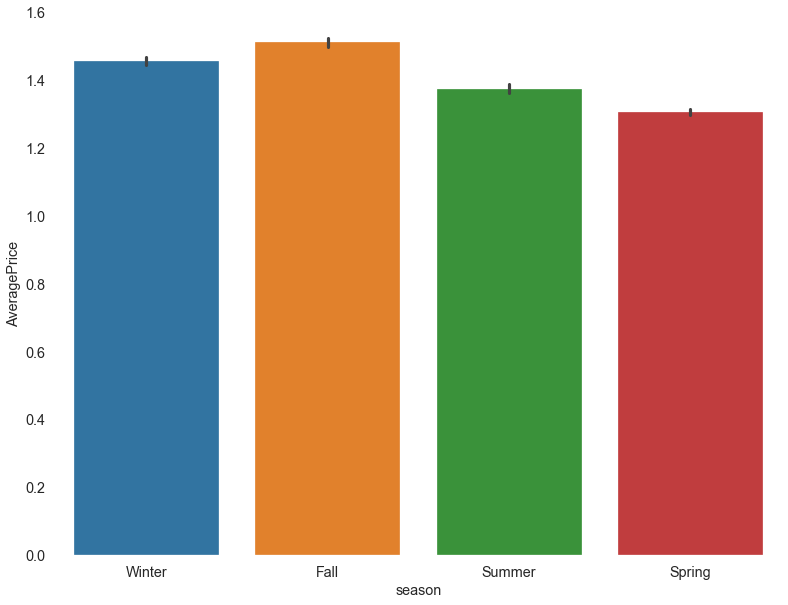

In [24]:
# How dose season affect avocado's price?
sns.barplot(data=df, x='season', y="AveragePrice");

Yếu tố mùa ảnh hưởng dến giá của bơ nhưng không đáng kể. Nhìn trên chúng ta có thể thấy mức độ trên lệch cao nhất nằm ở khoảng 0.2. Đỉnh giá là vào mùa thu, và đáy giá nằm vào mùa xuân. Điều này cũng hợp lý, vì trái cây ăn quả thường bội thu vào mùa xuân.

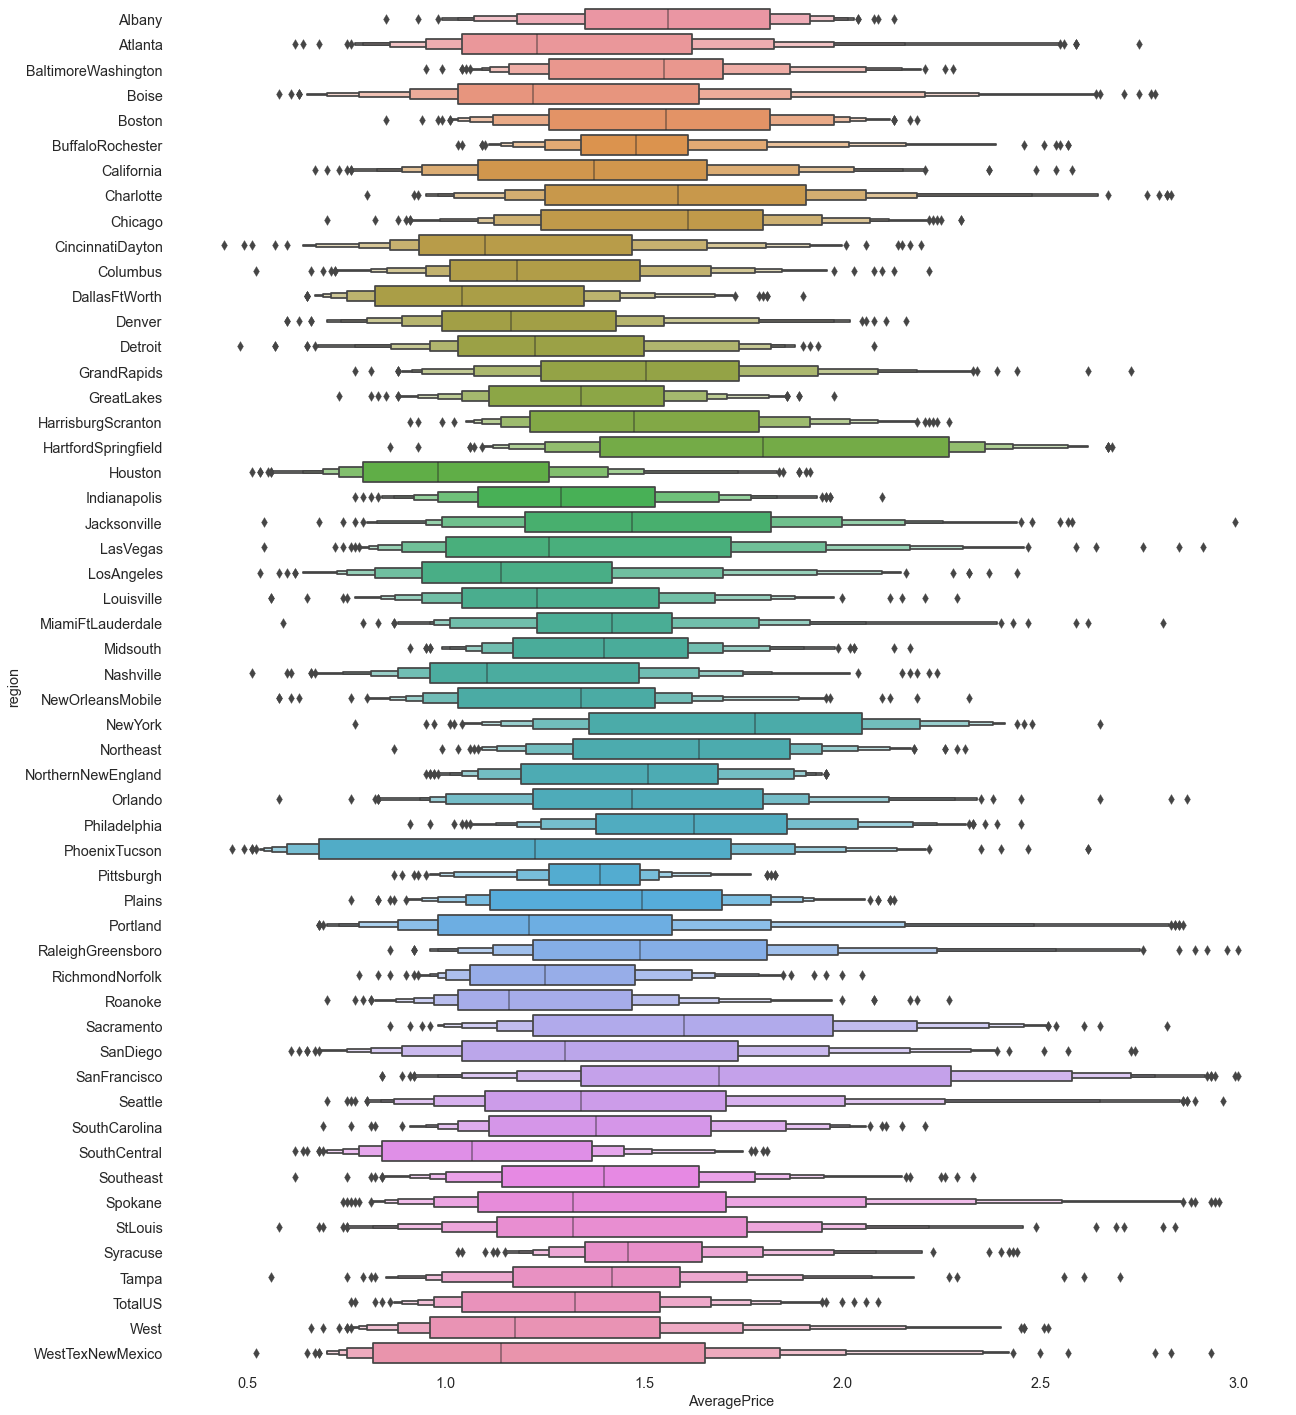

In [25]:
# How dose region affect avocado's price?
plt.figure(figsize=(20,25))
sns.boxenplot(data=df, y='region', x="AveragePrice");

Nhìn trên chúng ta có thể thấy mức giá quả bơ thay đổi đáng kể khắp lãnh thổ nước Mỹ. Có lẽ vì yếu tố thời tiết thay đổi qua các bang, nên mức giá của quả bơ cũng sẽ bị ảnh hưởng.

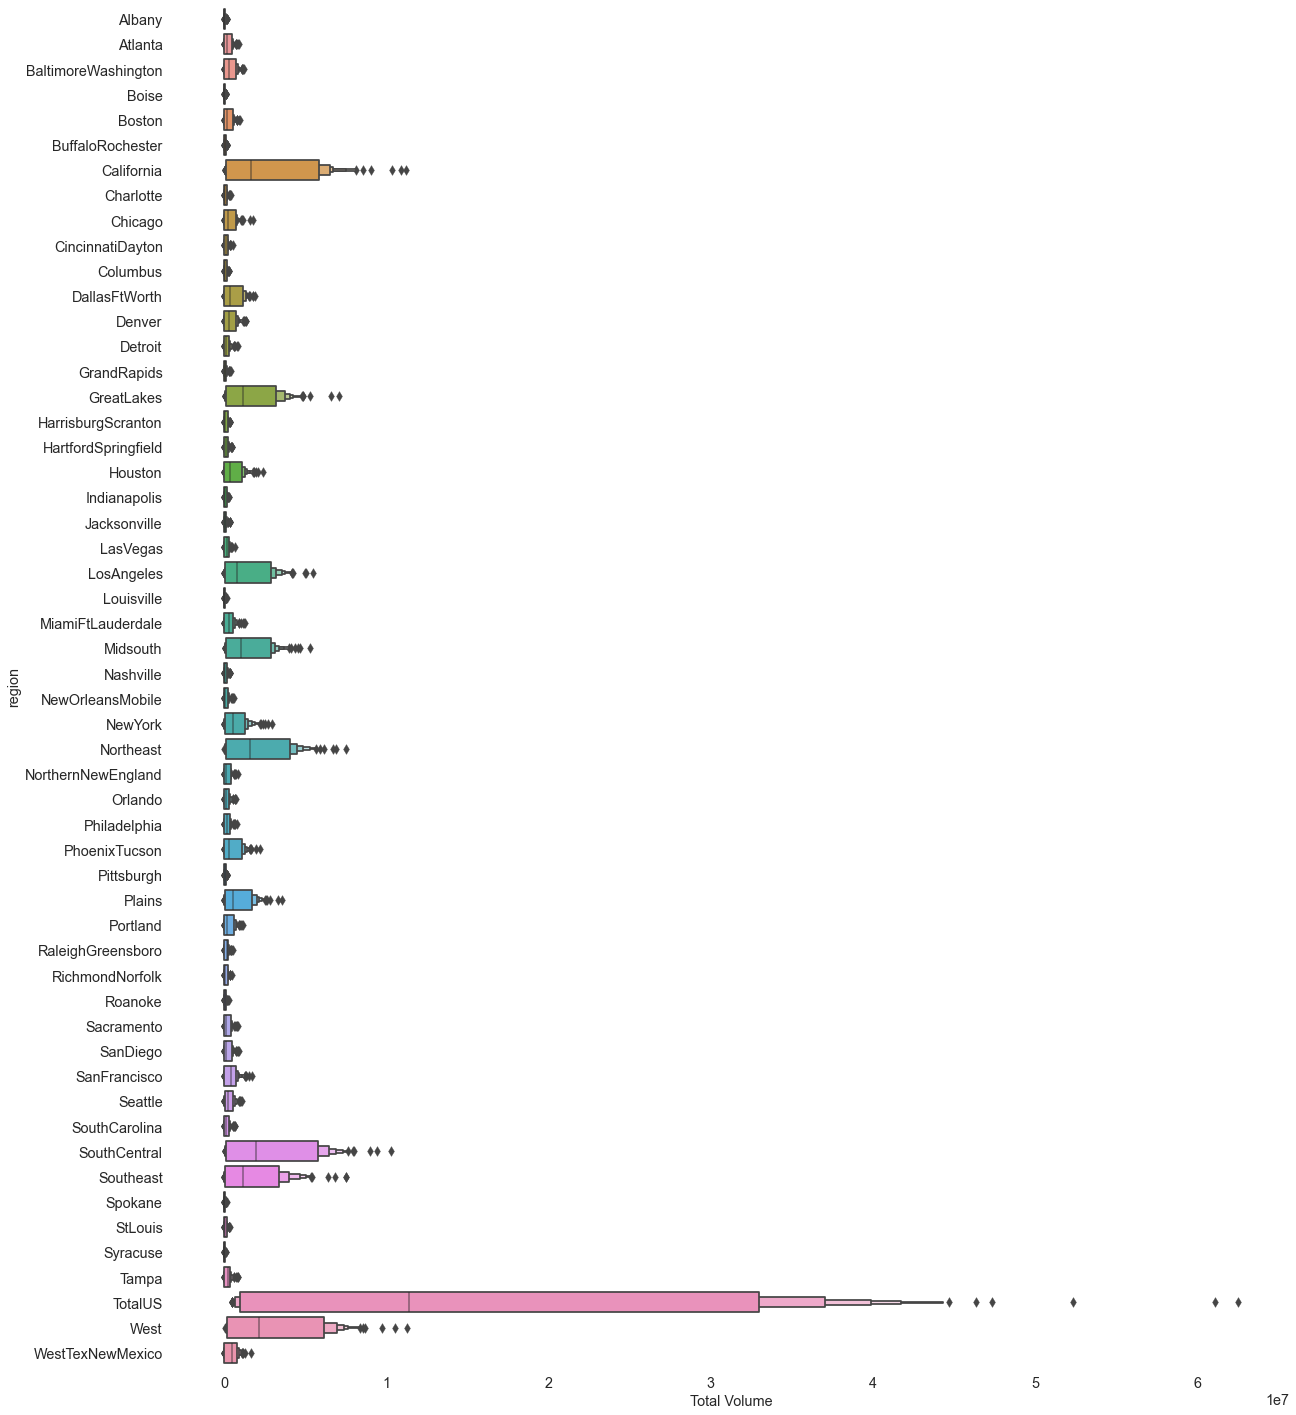

In [26]:
# How much avocado had been sold for each region?
plt.figure(figsize=(20,25))
sns.boxenplot(data=df, y='region', x="Total Volume");

Mức độ tiêu thụ lượng bơ thay đổi đáng kế qua các bang, có lẽ chúng ta nên cân nhắc thêm về số lượng dân cư trước khi có nhận xét thêm. Nhưng nhìn chung các bang lớn tiêu thụ lượng bơ nhiều hơn.

<AxesSubplot:xlabel='year', ylabel='Total Volume'>

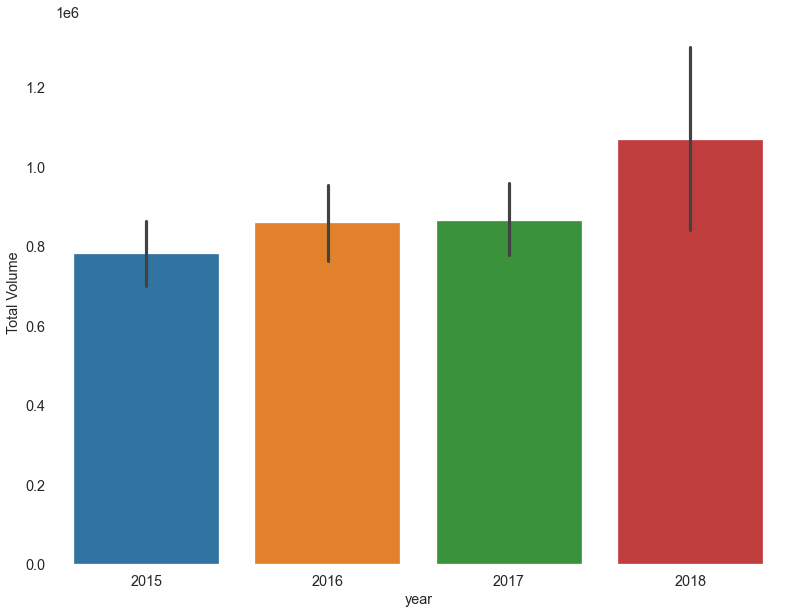

In [27]:
# The year has the highest total volume sell
sns.barplot(data = df, x = 'year', y = 'Total Volume')

Vậy là năm 2018 bán được khá nhiều hàng hơn năm ngoái, nên công ty này đang chóp thời cơ để mở rộng lãnh thổ của mình.

<AxesSubplot:xlabel='season', ylabel='Total Volume'>

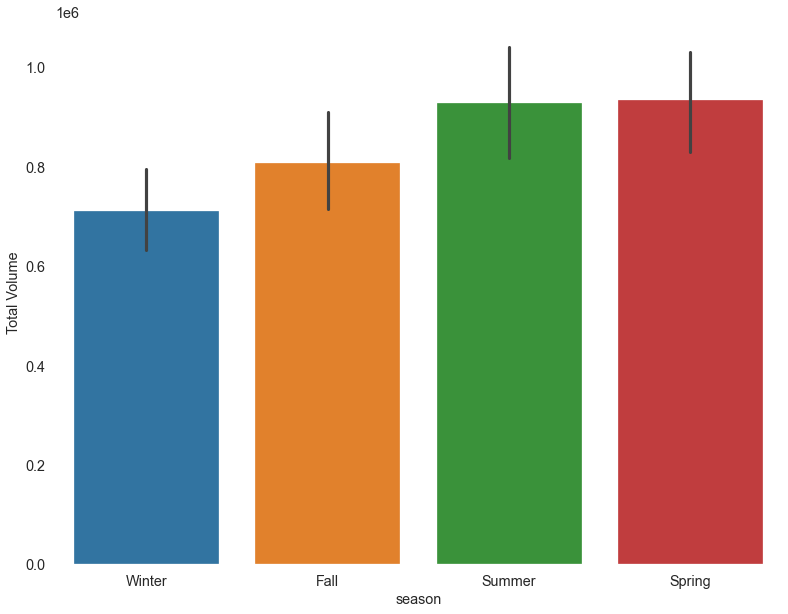

In [28]:
# Did season affects the selling?
sns.barplot(data = df, x = 'season', y = 'Total Volume')

Từ bảng này chúng ta có thể thấy, chúng ta bán được nhiều quả bơ vào mùa hè với mùa xuân. Đầu năm khi cây quả đua nhau nảy nở. Đương nhiên việc bán bơ vào hai mùa này cũng mang nhiều tính cạnh tranh hơn.

In [29]:
df.columns

Index(['Date', 'AveragePrice', 'Total Volume', '4046', '4225', '4770',
       'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags', 'type', 'year',
       'region', 'season'],
      dtype='object')

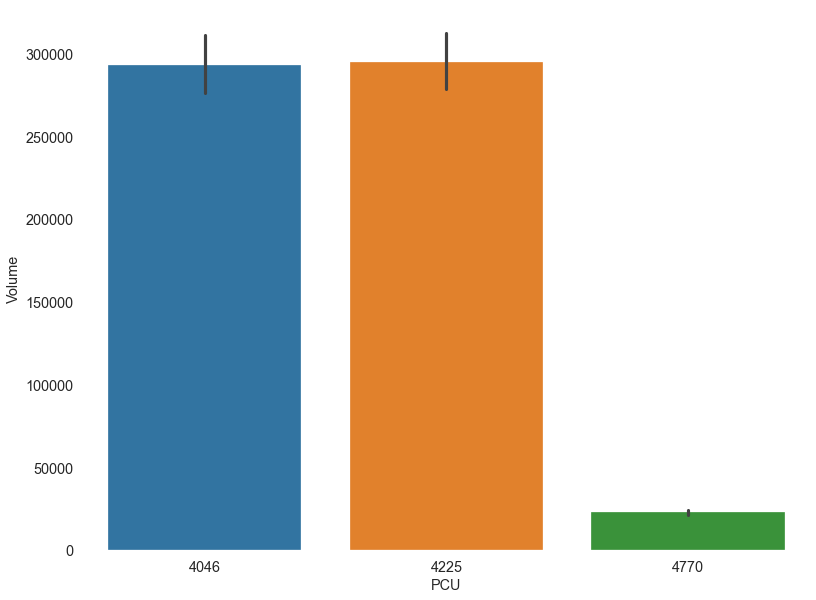

In [30]:
# Loại bơ nào được ưu chuộng nhất?
temp_table = pd.melt(df[['4046', '4225', '4770']], var_name='PCU', value_name='Volume')
sns.barplot(data = temp_table, x = 'PCU', y = 'Volume');

Vậy là các quả bơ có mã là 4770 không bán được nhiều. Khả năng cao là vì chúng mắc tiền hoặc hiếm. Còn hai loại quả bơ còn lại được bán khá đều nhau.

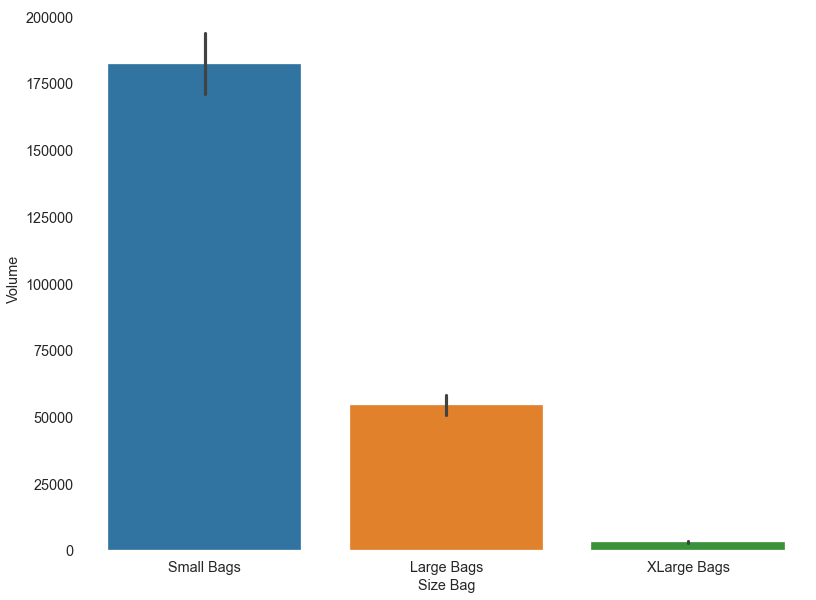

In [31]:
# How much the customer will buy in each time?
temp_table = pd.melt(df[['Small Bags', 'Large Bags', 'XLarge Bags']], var_name='Size Bag', value_name='Volume')
sns.barplot(data = temp_table, x = 'Size Bag', y = 'Volume');

Vậy mỗi lần khách hàng mua bơ, chỉ thường hay mua một số lượng nhỏ. Vì quả bơ cũng mắc với lại cũng không cần nhiều để chế biến hoặc ăn. Do đó chiến lược của chúng ta nên tập trung vào chất lượng của quả bơ thay vì sản xuất số lượng lớn.

# Step 5: Build model

In [32]:
def split_x_y(data):
    X = data.copy()
    y = X.pop('AveragePrice')
    return X,y

In [33]:
#Split train and test
X, y = split_x_y(data)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state=0)

In [34]:
# run model 8x with 60/30 split intentionally leaving out 10%
cv_split = ShuffleSplit(n_splits = 5, test_size = .3,
                        train_size = .6, random_state = 0)

In [35]:
#Define param_grids
param_grids = [
    #Random Forest
    {'n_estimators': [100, 200],
     'max_features': ['auto', 'log2'],
     'criterion': ["friedman_mse", "poisson"]},

    #KNN
    {'n_neighbors': list(range(2, 20, 2))},

    #LinearRegression
    {'fit_intercept': [True, False]},

    #SVR
    {'C': [1, 10, 100],
     'gamma': [0.1, 1]},

    #Decision Tree
    {'max_depth': [4, 6, 8, None],
     'max_features': ['auto', 'log2'],
     'criterion': ["friedman_mse", "poisson"]},

    #XGBoost
    {}
]

MLA = [
    RandomForestRegressor(),
    KNeighborsRegressor(),
    LinearRegression(),
    SVR(),
    DecisionTreeRegressor(),
    XGBRegressor()
]

In [36]:
scoring = pd.DataFrame(columns=['algorithm', 'best_params', 'score_train', 'score_test', 'fit_time'])
row = 0

start_total = time.perf_counter()
for mla, param in zip(MLA, param_grids):
    rscv = RandomizedSearchCV(mla, param, cv = cv_split, return_train_score=True, n_jobs=-1)
    rscv.fit(X_train, y_train)

    best_index = rscv.best_index_
    scoring.loc[row, 'algorithm'] = rscv.best_estimator_.__class__.__name__
    scoring.loc[row, 'best_params'] = str(rscv.best_params_)
    scoring.loc[row, 'score_train'] = rscv.cv_results_['mean_train_score'][best_index]
    scoring.loc[row, 'score_test'] = rscv.cv_results_['mean_test_score'][best_index]
    scoring.loc[row, 'fit_time'] = rscv.cv_results_['mean_fit_time'][best_index]
    row+=1

run_total = time.perf_counter() - start_total
print('Total optimization time was {:.2f} minutes.'.format(run_total/60))

C:\Users\PC\anaconda3\envs\dstn\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
C:\Users\PC\anaconda3\envs\dstn\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
C:\Users\PC\anaconda3\envs\dstn\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
C:\Users\PC\anaconda3\envs\dstn\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
C:\Users\PC\anaconda3\envs\dstn\

Total optimization time was 5.29 minutes.


In [37]:
scoring.sort_values(by='score_test', ascending=False)

algorithm                                        best_params  \
3                    SVR                           {'gamma': 0.1, 'C': 100}   
5           XGBRegressor                                                 {}   
1    KNeighborsRegressor                                 {'n_neighbors': 4}   
0  RandomForestRegressor  {'n_estimators': 200, 'max_features': 'auto', ...   
2       LinearRegression                            {'fit_intercept': True}   
4  DecisionTreeRegressor  {'max_features': 'log2', 'max_depth': None, 'c...   

  score_train score_test   fit_time  
3    0.766204   0.725647  15.303286  
5     0.86015   0.718451   3.561386  
1    0.834486   0.709429   0.026529  
0    0.959414   0.704562  19.220313  
2      0.6464   0.635169   0.158575  
4         1.0   0.577261   0.085971

Nhìn bảng kết quả trên chúng ta thấy thuật toán SVR cho kết quả tốt nhất, không có dấu hiệu overfiting, mặc dù thời gian chạy hơi lâu nhưng không đáng kể.
Ngoài ra các modle khác như XGB, KNN, RFR đều có xu hướng bị overfiting nên nhưng model này có lẽ sẽ không phù hợp.

# Step 6: Create best model and Report

In [38]:
#Init bestmodel
best_model = SVR(gamma=0.1, C=100)
best_model.fit(X_train, y_train)

SVR(C=100, gamma=0.1)

In [39]:
y_pred = best_model.predict(X_test)

In [40]:
y_test_np = np.array(y_test)

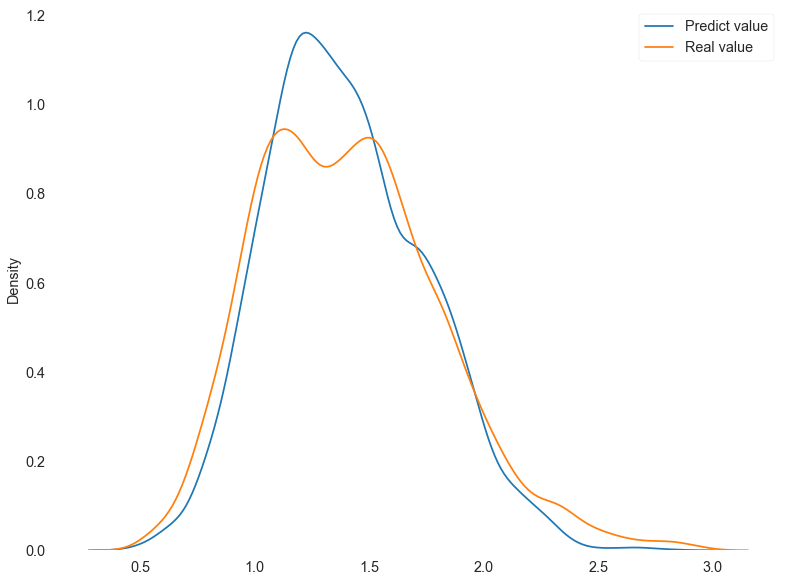

In [41]:
f, ax = plt.subplots()
sns.kdeplot(x = y_pred, label = 'Predict value', ax = ax)
sns.kdeplot(x = y_test_np, label = 'Real value', ax = ax)

plt.legend()
plt.show()

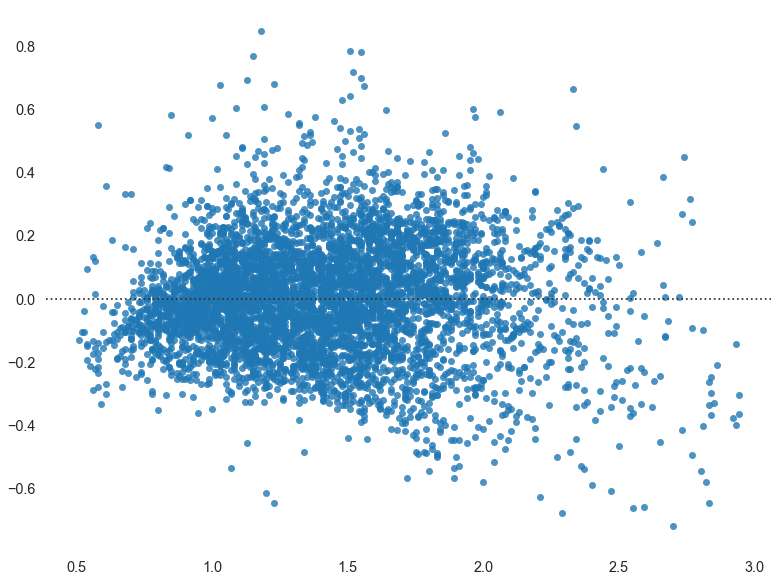

In [42]:
sns.residplot(x = y_test_np, y= y_pred);

Nhìn kết quả hai biểu đồ trên, chúng ta có thể nhận xét là:
1. Model này dự đoán không tốt tại các giá trị trung bình
2. Mức độ dao động sai số nằm trong khoảng từ nhiều nhất là 80cent/quả hoặc -60cent/quả.

In [43]:
true_std = round(np.std(y_test_np),2)
predict_std = round(mean_squared_error(y_test, y_pred),2)
print(f'True std: {true_std}, predict std: {predict_std}. Ratio between them is {true_std/predict_std}')

True std: 0.4, predict std: 0.04. Ratio between them is 10.0


Dộ lệch chuẩn trong tập dữ liệu là 40 cent, trong dữ liệu predict là 4 cent. Chênh lệch gấp 10 lần, điều đó cho chúng ta thấy được là thực tế độ biến động giá cả phức tạp hơn 10 lần so với những gì dự đoán trong đây. Biến động giá cả tượng trưng cho biến động nhu cầu tiêu thụ, do đó chúng ta có thể cân nhắc thêm nhiều yêu tố khác để hiểu rõ hơn.

Đương nhiên những gì chúng ta nhắm đến, là qua mô hình dự đoán này, chúng ta có thể rút ra một mẫu mặt chung cho các thuộc tính tiềm năng để mở rộng kinh doanh cho công ty. Vì thế một mô hình dự đoán ít biến động hơn sẽ cho ra một cái nhìn mang tính gợi ý và tổng quát hơn so với sự hỗn tạp của bên ngoài. Từ đó chúng ta nhắm đến mục tiêu đó, có thể sẽ không chính xác hoàn toàn, như đó cũng là một lời nhắc mang tính chỉ dẫn.

Nên nhớ là mô hình dự đoán cho ra kết quả chính xác đến 72%, chênh lệch thực tế cao nhất là 80cent/quả. Vậy nên chúng ta cũng có thể cân nhắc tin cậy về lời dự đoán này.

Bây giờ thì bước tiếp theo, chúng ta sẽ lọc ra các features tiềm năng cho mục tiêu mở rộng thị trường bơ tại nước Mỹ.

In [44]:
best_model.fit(X, y)

SVR(C=100, gamma=0.1)

In [45]:
#Concat raw data to predict data for analysis
viewing = df
viewing['pred_AveragePrice'] = best_model.predict(X)
viewing.head()

C:\Users\PC\anaconda3\envs\dstn\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Date  AveragePrice  Total Volume     4046       4225    4770  \
0 2015-12-27          1.33      64236.62  1036.74   54454.85   48.16   
1 2015-12-20          1.35      54876.98   674.28   44638.81   58.33   
2 2015-12-13          0.93     118220.22   794.70  109149.67  130.50   
3 2015-12-06          1.08      78992.15  1132.00   71976.41   72.58   
4 2015-11-29          1.28      51039.60   941.48   43838.39   75.78   

   Total Bags  Small Bags  Large Bags  XLarge Bags          type  year  \
0     8696.87     8603.62       93.25          0.0  conventional  2015   
1     9505.56     9408.07       97.49          0.0  conventional  2015   
2     8145.35     8042.21      103.14          0.0  conventional  2015   
3     5811.16     5677.40      133.76          0.0  conventional  2015   
4     6183.95     5986.26      197.69          0.0  conventional  2015   

   region  season  pred_AveragePrice  
0  Albany  Winter           1.434848  
1  Albany  Winter           1.440823  
2  Albany  Winter           1.330454  
3  Albany  Winter           1.413986  
4  Albany  Winter           1.440733

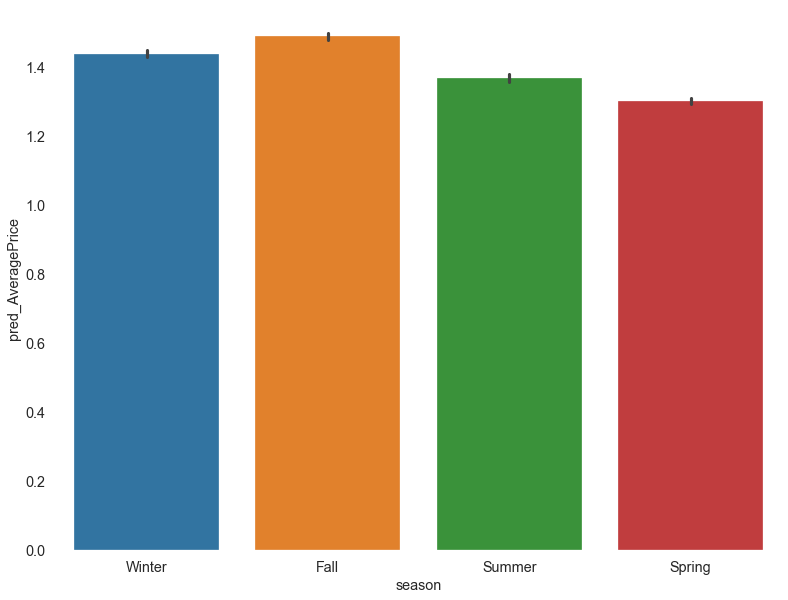

In [53]:
#Which season giving the highest demand
sns.barplot(data=viewing, x='season', y="pred_AveragePrice");

Lượng nhu cầu mua bơ tăng vào mùa thu, vậy nên chúng ta nên cân nhắc phương pháp có thể sản xuất bơ vào thời gian này, hoặc một cách thức bảo quản để có thể bán số lượng lớn bơ vào thời gian này. Tuy nhiên việc tăng lượng như cầu là không nhiều (20cent/quả), nếu chi phí cho phương pháp này chênh lệch quá lớn thì không đáng giá phải để ý về việc này. Thay vào đó chúng ta có thể tạo một số sự kiện hoặc chiến lược vào thời gian này như là một cách đầu tư để câu khách cho các mùa xuân và mùa hè.

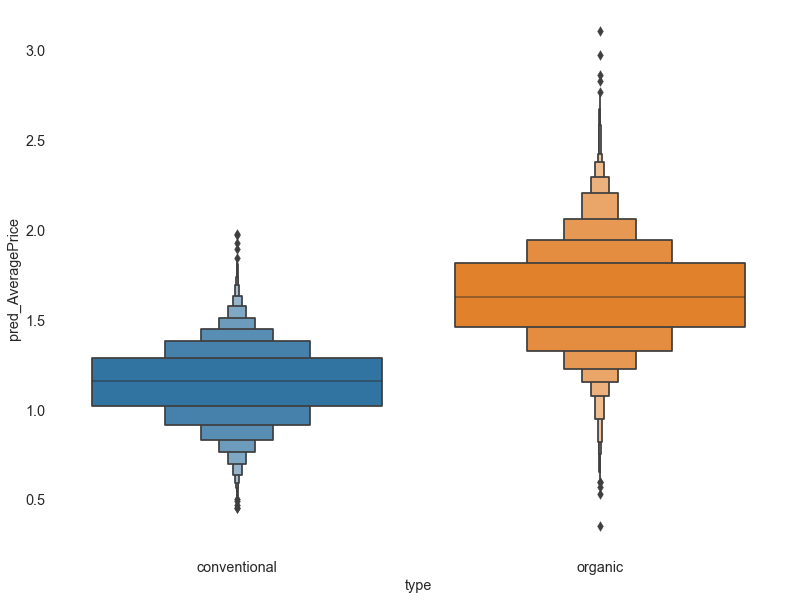

In [47]:
#Which type of avocado giving the highest demand?
sns.boxenplot(data=viewing, x='type', y="pred_AveragePrice");

Bơ hữa cơ cho giá thành mắc hơn. Có thể vì bơ hữa cơ giàu dinh dương, ngon hơn. Cũng như đã có đề cập ở trên vì người dân chỉ mua bơ với số lượng nhỏ/mỗi lần mua. Nên chiến lược của chúng ta nên tập trung vào chất lượng của bơ nhiều hơn.

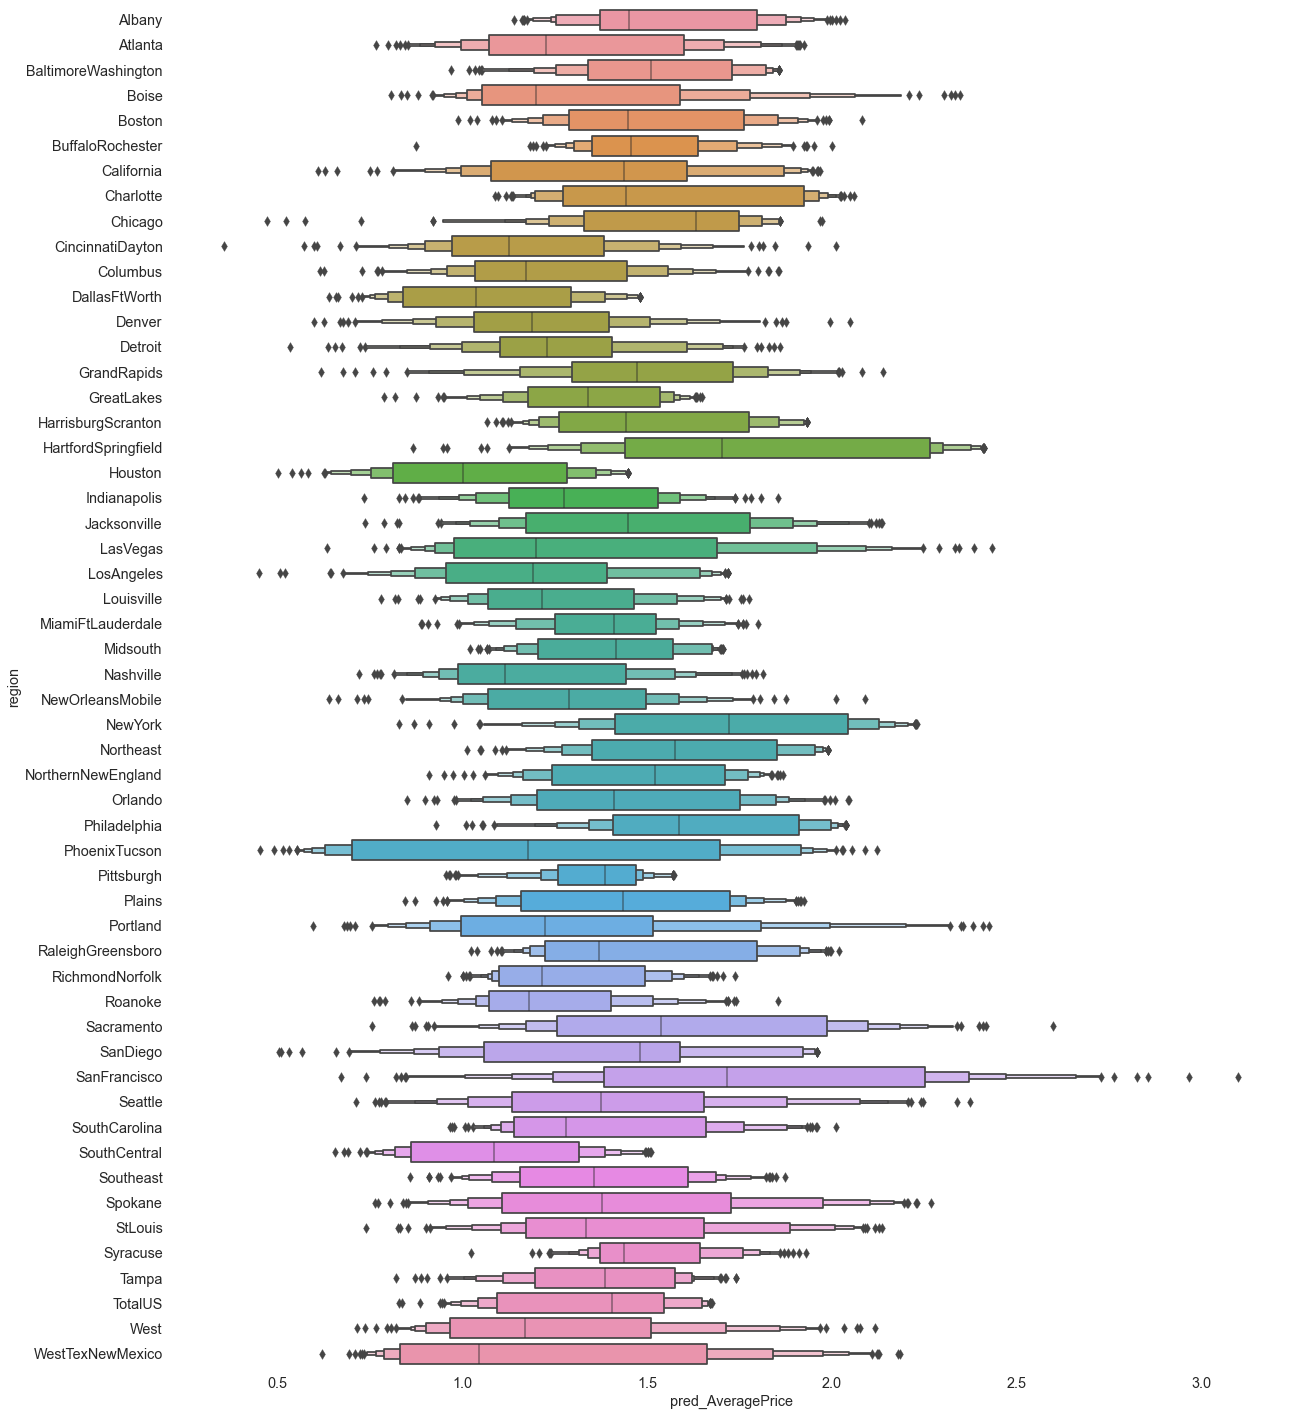

In [48]:
#Which region giving the highest demand?
plt.figure(figsize=(20,25))
sns.boxenplot(data=viewing, y='region', x="pred_AveragePrice");

Có thể thấy rõ, SanDiego, SanFrancisco, HartFoldSpringField là các bang có triển vọng để triển khai dự án mở rộng của công ty.

## Save model for later use

In [49]:
import pickle

In [52]:
#Saving model
with open('models/regression_price_model', 'wb') as files:
    pickle.dump(best_model, files)